In [1]:
import tensorflow as tf
import csv
from PIL import Image
import numpy as np
import PIL.ImageOps    
import cv2
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
files = []
action = []


with open("1/out.csv" , "r") as f :
    data = csv.reader(f, delimiter=',')
    for i in data:
        if(i[0] == 1):
            action.append(0)
        else:
            action.append(1)
        files.append(i[1])
        



In [52]:
def parse_function(filename,basewidth):
    img = Image.open(filename).convert('L')
    img = PIL.ImageOps.invert(img)
    wpercent = (basewidth/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((basewidth,hsize), Image.ANTIALIAS)    
    return img


x_v = [np.array(parse_function(i,270)).flatten()  for i in files ] 
y_v = action 

tf.set_random_seed(777)  

In [41]:

x_inp = tf.placeholder(tf.float32, [None, 20250]) 
y = tf.placeholder(tf.float32, [None])

x = tf.reshape(x_inp, [-1, 75, 270, 1])

In [42]:
weight_conv1  = tf.Variable(tf.random_normal([5,5,1,32])) 
weight_conv2  = tf.Variable(tf.random_normal([5,5,32,70]))
weight_fc     = tf.Variable(tf.random_normal([5 * 18 * 64  ,20250]))
weight_out    = tf.Variable(tf.random_normal([20250,1]))



In [43]:
bias_conv1  = tf.Variable(tf.random_normal([32])) 
bias_conv2  = tf.Variable(tf.random_normal([70]))
bias_fc     = tf.Variable(tf.random_normal([20250]))
bias_out    = tf.Variable(tf.random_normal([1]))

In [44]:
conv1     = tf.add(tf.nn.conv2d(x , weight_conv1 , strides=[1,1,1,1] , padding="SAME") , bias_conv1) 
max_pool1 = tf.nn.avg_pool(conv1 , ksize=[1,1,1,1] , strides=[1,1,1,1] , padding="SAME") 


In [45]:
conv2     = tf.add(tf.nn.conv2d(max_pool1 , weight_conv2 , strides=[1,1,1,1] , padding="SAME") , bias_conv2)
max_pool2 = tf.nn.avg_pool(conv2 , ksize=[1,10,10,1] , strides=[1,10,10,1] , padding="SAME") 


In [46]:
fc = tf.reshape(max_pool1 , [-1 , 5 * 18 * 64  ])
fc = tf.nn.relu( tf.add(tf.matmul(fc , weight_fc) , bias_fc) )
out = tf.matmul(fc , weight_out) + bias_out


In [47]:
cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits_v2(logits=out, labels=y) )
optimizer = tf.train.GradientDescentOptimizer(learning_rate=.0000000000000001).minimize(cost)




In [48]:
correct_prediction = tf.equal(tf.cast(tf.argmax(out, 1),"float64"),tf.cast(y , "float64") )
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float32"))

In [49]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

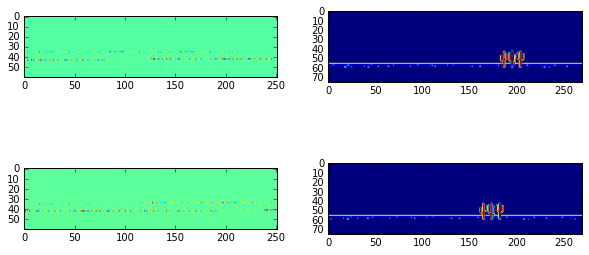

In [58]:
fig, ((ax1, ax2) , (ax3,ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(10,5))

fig = sess.run(max_pool2 , feed_dict={x_inp : [x_v[51]] })
ax1.imshow(fig.reshape([ 10 * 6, 7 * 36])).figure
fig = sess.run(x , feed_dict={x_inp : [x_v[51]] })
ax2.imshow(fig.reshape([75,270])).figure
fig = sess.run(max_pool2 , feed_dict={x_inp : [x_v[52]] })
ax3.imshow(fig.reshape([ 10 * 6, 7 * 36])).figure
fig = sess.run(x , feed_dict={x_inp : [x_v[52]] })
ax4.imshow(fig.reshape([75,270])).figure



In [ ]:

sess = tf.Session()
sess.run(tf.global_variables_initializer())

hm_epochs = 2
batch_size = 100



for epoch in range(hm_epochs):
    epoch_loss = 0
    for i in range(int(len(files)//batch_size)):
        epoch_x, epoch_y = x_v[ (i * batch_size) : (i +1 ) * batch_size ] , y_v[ (i * batch_size) : (i +1 ) * batch_size ] 
        #print sess.run(max_pool1, feed_dict={x_inp: epoch_x, y: epoch_y}).shape
        _, c = sess.run([optimizer, cost], feed_dict={x_inp: epoch_x, y: epoch_y})
        epoch_loss += c
        print (i * batch_size) , (i +1 ) * batch_size , i , c
        #print map(sum , sess.run([weight_conv1 , weight_conv2 , weight_fc , weight_out ], feed_dict={x_inp: epoch_x, y: epoch_y}) )
    print 'Completed Epoch# : ', epoch, ' : Epochs Left : ',hm_epochs-epoch - 1,' : loss : ',epoch_loss

sess.close()
